# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, we will be predicting the prices of the houses.


In [1]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sqlalchemy import create_engine
import warnings
import pandas_profiling as pp

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning 

First, we will clean column names by stripping spaces and convert to lower case. Then, we will detect null values and fill in with interpolation since the data is a time series.  

In [2]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


There are 81 attributes and 1,460 rows in this dataset. Currently, majority of the attributes are categorical variables describing features of our the target variable, sale price. There are also many continous variables, such as lot area and sizing of the house. 

We will continue exploring the data by taking a closer look into the data types and search for missing values. Then, we will fill in the missing values with the appropriate technique.

In [3]:
# Verify data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

There appears to be multiple missing values in the the dataframe. Let's investigate the null values and then revisit the data types. 

In [4]:
# Percentage of missing values

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


We can observe that the top 6 variables in the table are missing more than 15% of datapoints. Since these features don't appear to be the top qualities of what people may prioritize when purchasing a house, we will delete these columns. 

The remaining variables share common characteristics and the number of missing values with other columns. For example, there are 5 columns describing the garage feature of a house. All of the garage variables are missing 81 values, which may have occurred from logging a particular observation. Home buyers would more likely be interested in the number of cars a garage can store, we will delete these extra garage variables. This logic will be applied to the remaining variables as well. 


In [5]:
# Drop missing data

df = df.drop((missing_data[missing_data['Total'] >= 1]).index,1)

# Check for missing data
df.isnull().sum().max() 

0

There doesn't appear to be anymore missing values so we will treat outliers in the following section.

## Exploratory 
First, let's look at the distribution of our target variable: sale price. Investigating how our target is distributed helps us understand the relationship between the target and the features. 

Text(0.5, 1.0, 'Sale Price')

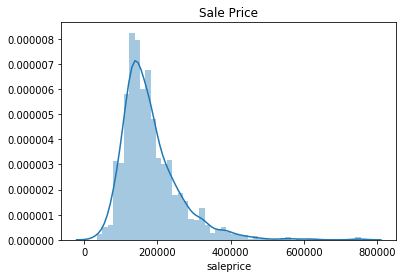

In [14]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. This may be due to some prices being listed at $750,000 and above. 
We will treat the skewness by performing a log transformation. 

Text(0.5, 1.0, 'Log of Sale Price')

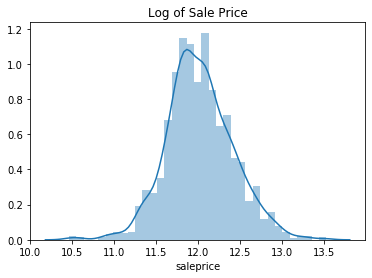

In [13]:
# Log of sale price

df['log_saleprice'] = np.log(df.saleprice)

sns.distplot(np.log(df.saleprice))
plt.title('Log of Sale Price')

Sale price looks relatively normally distributed now. We will continue by exploring which variables are most correlated to sale price to determine features for our linear regression model. 

First, we will explore the numeric variables. 

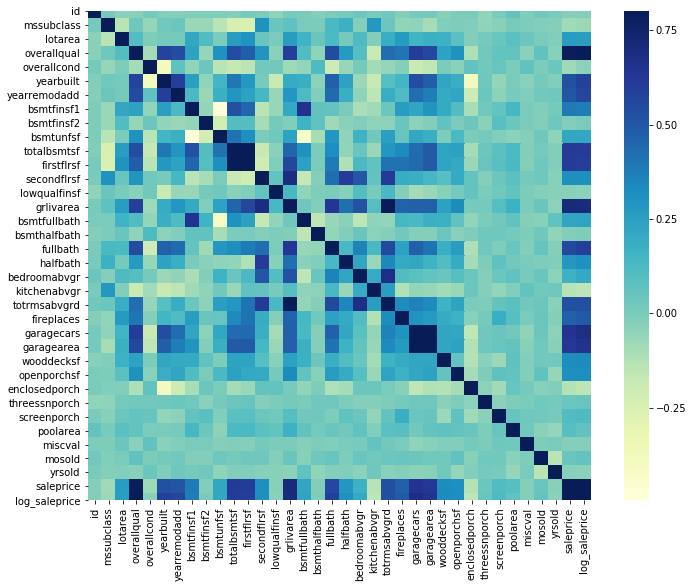

In [18]:
# Draw heatmap
corrmat = df.corr()

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

In [20]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
np.abs(df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
log_saleprice    0.948374
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
fireplaces       0.466929
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

## Feature Engineering
With the information of winsorized life expectancy coorelation to other variables, we will propose some feature variables. First, let's see the distribution of our target variable, life expectancy.